# Tasselled Cap Wetness Index Calculation

| Authors:  | Bex Dunn|
|----------|----------------|
| Created: | Feb 20, 2019 |
| Last edited: | April 4, 2019 |

**Requirements:**

You need to run the following commands from the command line prior to launching jupyter notebooks from the same terminal so that the required libraries and paths are set:

`module use /g/data/v10/public/modules/modulefiles` 

`module load dea`

This notebook assumes you have cloned the dea-notebooks repository by following the instructions on [DEA notebooks using command line git](https://github.com/GeoscienceAustralia/dea-notebooks#dea-notebooks-using-command-line-git) or [DEA notebooks using Github](https://github.com/GeoscienceAustralia/dea-notebooks#dea-notebooks-using-github). If you didn't, you will need to download any scripts that fail in the first cell into your relative directory so that the notebook will have access to those scripts. `"../"` means the directory above the directory you are working in, and `"./"` means the current directory. 

If you find an error or bug in this notebook, please either create an 'Issue' in the Github repository, or fix it yourself and create a 'Pull' request to contribute the updated notebook back into the repository (See the repository [README](https://github.com/GeoscienceAustralia/dea-notebooks/blob/master/README.rst) for instructions on creating a Pull request).



__Background:__ Data from the [Landsat](https://landsat.usgs.gov/about-landsat) 5,7 and 8 satellite missions are accessible through [Digital Earth Australia](http://www.ga.gov.au/about/projects/geographic/digital-earth-australia) (DEA). 

The *Tasseled Cap Index (TCI)* is a method of reducing 6 bands of satellite data (BLUE, GREEN, RED, NIR, SWIR1, SWIR2) to 3 bands (Brightness, Greenness, Wetness) using a Principal Components Analysis and Procrustes' Rotation [(Roberts et al 2018)](##References). This notebook uses the published coefficients of [Crist 1985](##References) as applied to Digital Earth Australia's Landsat satellite data.This notebook produces the wetness index.

__What does this notebook do?:__ This notebook takes a supplied shapefile of a polygon and queries the datacube Landsat surface reflectance data. It calculates tasselled cap wetness. The results and input surface reflectance are output as geotiffs for each individual scene.

### import modules and scripts

In [42]:
import datacube
import datetime
import fiona
import geopandas as gpd
import numpy as np
import pandas as pd
import rasterio.mask
import rasterio.features
from shapely import geometry
import seaborn as sns
import sys
import xarray as xr

import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

from datacube.storage import masking
from datacube.utils import geometry
from datacube.helpers import ga_pq_fuser, write_geotiff

sys.path.append('../10_Scripts')
import DEADataHandling, DEAPlotting, TasseledCapTools

dc = datacube.Datacube(app='tcw')

%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Set up polygon

In [43]:
#change the path here if you want a different polygon
poly_path = '/g/data/r78/rjd547/shapefiles/melbourne_water.shp'

In [44]:
#open the polygon
with fiona.open(poly_path) as shapes:
        crs = geometry.CRS(shapes.crs_wkt)
        first_geometry = next(iter(shapes))['geometry']
        geom = geometry.Geometry(first_geometry, crs=crs)

<Figure size 432x288 with 0 Axes>

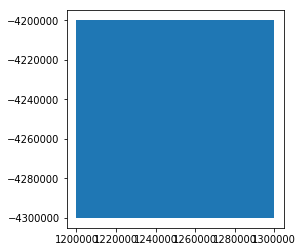

In [45]:
#plot polygon to check it looks ok
plt.clf()
shape_plot = gpd.read_file(poly_path)
shape_plot.plot()
plt.show()

### set up DEA query

In [46]:
query = {'geopolygon': geom,
         'time': ('2009-06-01', '2010-09-01')
         }

## Set up datasets

### set cloudmasking threshold and load landsat nbart data

In [47]:
#set cloudmasking threshold and load landsat nbart data
landsat_masked_prop = 0.90 # 0.90

#set the masking dictionary up for science analysis: remove saturated and uncontiguous values
ls578_ds = DEADataHandling.load_clearlandsat(dc=dc, query=query, product='nbart', 
                mask_dict=dict(cloud_acca='no_cloud',
                 cloud_shadow_acca='no_cloud_shadow',
                 cloud_shadow_fmask='no_cloud_shadow',
                 cloud_fmask='no_cloud',
                 blue_saturated=False,
                 green_saturated=False,
                 red_saturated=False,
                 nir_saturated=False,
                 swir1_saturated=False,
                 swir2_saturated=False,
                 contiguous=True),
                mask_pixel_quality=True,
                masked_prop=landsat_masked_prop)

Loading ls5
    Loading 2 filtered ls5 timesteps
Loading ls7
    Ignoring SLC-off observations for ls7
    Skipping ls7; no valid data for query
Loading ls8
    Skipping ls8; no valid data for query
Returning ls5 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)


### mask the data with our original polygon to remove extra data 

In [60]:
data = ls578_ds
mask = rasterio.features.geometry_mask([geom.to_crs(data.geobox.crs)for geoms in [geom]],
                                           out_shape=data.geobox.shape,
                                           transform=data.geobox.affine,
                                           all_touched=False,
                                           invert=False)

In [61]:
#for some reason xarray is not playing nicely with our old masking function
mask_xr = xr.DataArray(mask, dims = ('y','x'))
ls578_ds = data.where(mask_xr==False)

### Plot our data as a false color image 

Populating the interactive namespace from numpy and matplotlib


<Figure size 432x288 with 0 Axes>

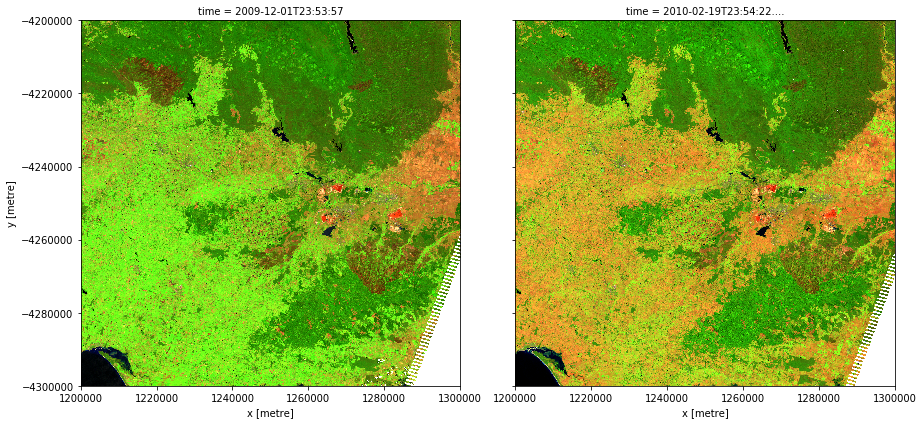

In [50]:
%pylab inline
plt.clf()
DEAPlotting.rgb(ls578_ds, bands=['swir1', 'nir', 'green'], col='time',col_wrap=4)
plt.show()

### Run the tasselled cap transform for our AOI

In [51]:
#transform the nbart into tci. Note I've set a lowish threshold on the TCI but we're only really dealing with the unthresholded results in this notebook.
tci = TasseledCapTools.thresholded_tasseled_cap(ls578_ds,wetness_threshold=-1200, drop=True , drop_tc_bands=False)

### get the wetness results

In [52]:
tcw = tci['wetness']

### plot the tasseled cap wetness for our AOI

In [53]:
tcw.max()


<xarray.DataArray 'wetness' ()>
array(2116.4497)

## Write geotiffs of wetness for each time we have imagery

In [54]:
#get attrs off our original dataset
tcw_dataset=tcw.to_dataset()
tcw_dataset.attrs=ls578_ds.attrs

### set up paths to write out outputs to

In [55]:
#get polygon name from the polygon path
polyname = poly_path.split('/')[-1].split('.')[0]

### change the path below to a path where you'd like things saved!

In [56]:
savefilepath = '/g/data/r78/rjd547/Melbourne_water/'+polyname

In [57]:
#set dataset equal to wetness dataset
ds = tcw_dataset
#write a geotiff to file for each timestep
if len(ds.time)==1:
    print('one timestep')
    for timestep in range(len(ds.time)):
        try:
            write_geotiff(savefilepath+'_TCW_'+timestep_date+'.tif', ds.isel(time =timestep))
            #complain if the file already exists but don't fail    
            print('wrote to GeoTIFF' )
        except RuntimeError as err:
            print("RuntimeError: {0}".format(err))
            
elif len(ds.time)>1:
    print('multiple timesteps') 
    #remove data percentage as it breaks the geotiff writer
    #ds = ds.drop('data_perc')
    for timestep in range(len(ds.time)):
        timestep_date =np.datetime_as_string(ds.time.isel(time=timestep))[0:10]
        try:
            write_geotiff(savefilepath+'_TCW_'+timestep_date+'.tif', ds.isel(time =timestep))
            #complain if the file already exists but don't fail    
            print('wrote to GeoTIFF' )
        except RuntimeError as err:
            print("RuntimeError: {0}".format(err))

multiple timesteps
wrote to GeoTIFF
wrote to GeoTIFF


## Write geotiffs of surface reflectance for each time we have imagery

In [58]:
for timestep in range(len(ds.time)):
    print(np.datetime_as_string(ds.time.isel(time=timestep))[0:10])

2009-12-01
2010-02-19


In [59]:
#set dataset equal to landsat dataset
ds = ls578_ds
#write a geotiff to file for each timestep
if len(ds.time)==1:
    print('one timestep')
    for timestep in range(len(ds.time)):
        try:
            write_geotiff(savefilepath+'_TCW_'+timestep_date+'.tif', ds.isel(time =timestep))
            #complain if the file already exists but don't fail    
            print('wrote to GeoTIFF' )
        except RuntimeError as err:
            print("RuntimeError: {0}".format(err))

elif len(ds.time)>1:
    print('multiple timesteps') 
    #remove data percentage as it breaks the geotiff writer
    #ds = ds.drop('data_perc')
    for timestep in range(len(ds.time)):
        timestep_date =np.datetime_as_string(ds.time.isel(time=timestep))[0:10]
        try:
            write_geotiff(savefilepath+'_LS_'+timestep_date+'.tif', ds.isel(time =timestep))
            #complain if the file already exists but don't fail    
            print('wrote to GeoTIFF' )
        except RuntimeError as err:
            print("RuntimeError: {0}".format(err))

multiple timesteps
wrote to GeoTIFF
wrote to GeoTIFF


## References

1. Roberts, D., Dunn,B., Mueller, N. 2018, *Open Data Cube Products Using High-Dimensional Statistics of Time Series*, in press.

2. E. P. Crist, *A tm tasseled cap equivalent transformation for reflectance
factor data*, Remote Sensing of Environment, vol. 17, no. 3, pp. 301-306, 1985.